# Linear Regression Applied: Insurance Cost Prediction

Here we'll be working through [Assignment 2](https://jovian.ai/aakashns/02-insurance-linear-regression) of the [Pytorch Zero-to-GANS course](https://jovian.ai/learn/deep-learning-with-pytorch-zero-to-gans), and demonstrating how to use personal data to predict annual medical costs.

In [39]:
project_name = 'pytorch-first-model'
assignment_name = 'zerotogans-a2'

First let's import the necessary tools.

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import pandas as pd
import matplotlib.pyplot as plt
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

## Step 1: Download and Explore Dataset

The dataset is public domain and available on [Kaggle](https://www.kaggle.com/mirichoi0218/insurance?select=insurance.csv), but Jovian have made it more accessibly downloadable, so we'll get it from there.

In [41]:
DATASET_URL = "https://hub.jovian.ml/wp-content/uploads/2020/05/insurance.csv"
DATA_FILENAME = "insurance.csv"
download_url(DATASET_URL, '../data')

Using downloaded and verified file: ../data/insurance.csv


In [42]:
df_raw = pd.read_csv(f'../data/{DATA_FILENAME}')
df_raw.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


The assignment wants us to personalize the data by taking a randomized sample of the data using our name as a source of random numbers.

In [43]:
def personalize_dataset(dataframe_raw, rand_str):
    dataframe = dataframe_raw.copy(deep=True)
    # drop some rows
    dataframe = dataframe.sample(int(0.95*len(dataframe)), random_state=int(ord(rand_str[0])))
    # scale input
    dataframe.bmi = dataframe.bmi * ord(rand_str[1])/100.
    # scale target
    dataframe.charges = dataframe.charges * ord(rand_str[2])/100.
    # drop column
    if ord(rand_str[3]) % 2 == 1:
        dataframe = dataframe.drop(['region'], axis=1)
    return dataframe

In [44]:
my_name = 'Peter'
df = personalize_dataset(df_raw, my_name)
df.head()

,age,sex,bmi,children,smoker,charges
240,23,female,37.0367,2,yes,44673.488828
651,53,female,39.9960,1,no,12272.464760
761,23,male,35.5520,1,no,2803.667800
836,36,male,31.8150,0,no,5106.590280
1147,20,female,32.2392,0,no,2623.419808


Now let's do some very basic initial exploration of the data.

In [45]:
num_rows, num_cols = df.shape
print(f'The dataframe has {num_rows} rows and {num_cols} columns')

The dataframe has 1271 rows and 6 columns


In [46]:
col_titles = df.columns
input_cols = col_titles.values
print(f'The dataframe column headings are {list(col_titles)}')

The dataframe column headings are ['age', 'sex', 'bmi', 'children', 'smoker', 'charges']


In [47]:
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
charges     float64
dtype: object

In [48]:
categorical_cols = ['sex', 'smoker']

Looking at the types of the variables, we can see that `sex` is a binary categorical variable...

In [49]:
df.sex.unique()

array(['female', 'male'], dtype=object)

...and so is `smoker`.

In [50]:
df.smoker.unique()

array(['yes', 'no'], dtype=object)

The target variable that we are interested in is `charges`. We can easily find its statistics, and plot its histogram.

In [51]:
output_cols = ['charges']
df.charges.describe()

count     1271.000000
mean     15513.173557
std      14125.570520
min       1301.373724
25%       5536.462094
50%      10958.810406
75%      19472.175274
max      73973.696492
Name: charges, dtype: float64

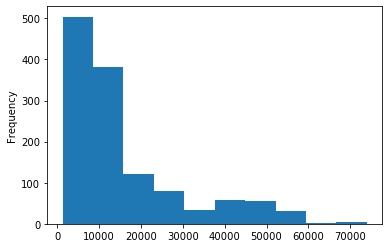

In [52]:
df.charges.plot.hist()

## Step 2: Prepare Dataset for Training

We're using PyTorch, so we need to convert our Pandas dataframe into a PyTorch tensor.

[Aakash suggests](https://jovian.ai/aakashns/02-insurance-linear-regression/v/5#C29) that we first turn it into a NumPy array, using his function.

In [53]:
def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array

In [54]:
inputs_array, targets_array = dataframe_to_arrays(df)
inputs_array, targets_array

(array([[2.30000000e+01, 0.00000000e+00, 3.70367000e+01, 2.00000000e+00,
         1.00000000e+00, 4.46734888e+04],
        [5.30000000e+01, 0.00000000e+00, 3.99960000e+01, 1.00000000e+00,
         0.00000000e+00, 1.22724648e+04],
        [2.30000000e+01, 1.00000000e+00, 3.55520000e+01, 1.00000000e+00,
         0.00000000e+00, 2.80366780e+03],
        ...,
        [5.90000000e+01, 0.00000000e+00, 3.71326500e+01, 1.00000000e+00,
         1.00000000e+00, 5.55602780e+04],
        [5.30000000e+01, 0.00000000e+00, 3.35825000e+01, 0.00000000e+00,
         0.00000000e+00, 1.22552660e+04],
        [4.80000000e+01, 0.00000000e+00, 3.36633000e+01, 0.00000000e+00,
         0.00000000e+00, 9.60906961e+03]]),
 array([[44673.488828],
        [12272.46476 ],
        [ 2803.6678  ],
        ...,
        [55560.277966],
        [12255.26602 ],
        [ 9609.069612]]))

Now we instantiate PyTorch tensors from those NumPy arrays.

In [55]:
inputs = torch.Tensor(inputs_array)
targets = torch.Tensor(targets_array)

print(f'Inputs tensor instantiated with dtype {inputs.dtype}')
print(f'Targets tensor instantiated with dtype {targets.dtype}')

Inputs tensor instantiated with dtype torch.float32
Targets tensor instantiated with dtype torch.float32


Next, we need to create PyTorch datasets and data loaders for training and validation. We start by creating a `TensorDataset`.

In [56]:
dataset = TensorDataset(inputs, targets)

In [57]:
val_percent = 0.15 # between 0.1 and 0.2
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size

# Use the random_split function to split dataset into 2 parts of the desired length
train_ds, val_ds = random_split(dataset, [train_size, val_size])

Now we can create data loaders for training and validation.

In [58]:
batch_size = 128
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

Let's look at a batch of data to verify everything is working so far:

In [59]:
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)

inputs: tensor([[4.7000e+01, 0.0000e+00, 3.6996e+01, 1.0000e+00, 1.0000e+00, 4.9845e+04],
        [3.5000e+01, 0.0000e+00, 3.4446e+01, 3.0000e+00, 1.0000e+00, 4.6381e+04],
        [4.4000e+01, 1.0000e+00, 2.2356e+01, 2.0000e+00, 0.0000e+00, 9.6309e+03],
        [2.7000e+01, 0.0000e+00, 2.3442e+01, 1.0000e+00, 0.0000e+00, 4.1318e+03],
        [2.9000e+01, 1.0000e+00, 2.8219e+01, 0.0000e+00, 0.0000e+00, 3.3259e+03],
        [4.3000e+01, 0.0000e+00, 3.5996e+01, 1.0000e+00, 0.0000e+00, 8.5210e+03],
        [2.7000e+01, 1.0000e+00, 3.0603e+01, 3.0000e+00, 0.0000e+00, 4.9425e+03],
        [2.3000e+01, 0.0000e+00, 3.7037e+01, 2.0000e+00, 1.0000e+00, 4.4673e+04],
        [6.3000e+01, 1.0000e+00, 3.1108e+01, 0.0000e+00, 0.0000e+00, 1.5533e+04],
        [6.4000e+01, 0.0000e+00, 3.9723e+01, 0.0000e+00, 0.0000e+00, 1.7286e+04],
        [1.8000e+01, 1.0000e+00, 3.2047e+01, 0.0000e+00, 1.0000e+00, 3.9130e+04],
        [6.0000e+01, 0.0000e+00, 2.6098e+01, 0.0000e+00, 0.0000e+00, 3.3551e+04],
        

## Step 3: Create a Linear Regression Model

The model is a straightforward linear regression. I've decided to use `mse_loss`  as my [loss function](https://pytorch.org/docs/stable/nn.functional.html#loss-functions).

In [60]:
input_size = len(input_cols)
output_size = len(output_cols)

In [61]:
class InsuranceModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size,output_size)                 
        
    def forward(self, xb):
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)        
        # Calcuate loss
        loss = nn.functional.l1_loss(out,targets)
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = nn.functional.mse_loss(out,targets)
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

Having defined the `InsuranceModel` class we can now use it.

In [62]:
model = InsuranceModel()

We can see the weights and biases of the model by listing the `model.parameters`.

In [63]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.1425, -0.2244, -0.3564, -0.0901, -0.0455,  0.1382]],
        requires_grad=True),
 Parameter containing:
 tensor([0.1428], requires_grad=True)]

## Step 4: Train the Model to Fit the Data

To train the model, we define a generic training loop that can be easily used for any problem.

In [64]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

In [65]:
result = evaluate(model, val_loader)
print(result)

{'val_loss': 400099328.0}


We are now ready to train the model.

In [66]:
epochs = 102
lr = 1e-2
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 4412545171456.0000
Epoch [40], val_loss: 13369363456.0000
Epoch [60], val_loss: 5784014422016.0000
Epoch [80], val_loss: 2655240060928.0000
Epoch [100], val_loss: 4234866065408.0000
Epoch [102], val_loss: 468032864.0000


In [67]:
epochs = 102
lr = 1e-4
history2 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 334242592.0000
Epoch [40], val_loss: 691788096.0000
Epoch [60], val_loss: 529489536.0000
Epoch [80], val_loss: 406762208.0000
Epoch [100], val_loss: 78109912.0000
Epoch [102], val_loss: 11009386.0000


In [68]:
epochs = 102
lr = 1e-6
history3 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 2469.1230
Epoch [40], val_loss: 87769.1719
Epoch [60], val_loss: 40169.8164
Epoch [80], val_loss: 45841.9062
Epoch [100], val_loss: 42969.0000
Epoch [102], val_loss: 75362.6406


In [69]:
epochs = 1000
lr = 1e-6
history4 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 102982.7188
Epoch [40], val_loss: 41945.2891
Epoch [60], val_loss: 26554.9492
Epoch [80], val_loss: 2544.5503
Epoch [100], val_loss: 36073.9961
Epoch [120], val_loss: 5575.0132
Epoch [140], val_loss: 1863.4648
Epoch [160], val_loss: 17136.9297
Epoch [180], val_loss: 23405.2930
Epoch [200], val_loss: 12024.3398
Epoch [220], val_loss: 17304.1504
Epoch [240], val_loss: 80226.6172
Epoch [260], val_loss: 4847.7588
Epoch [280], val_loss: 17197.8633
Epoch [300], val_loss: 6721.4985
Epoch [320], val_loss: 83699.6562
Epoch [340], val_loss: 11521.1094
Epoch [360], val_loss: 117584.1719
Epoch [380], val_loss: 5318.9736
Epoch [400], val_loss: 2040.0430
Epoch [420], val_loss: 3834.6768
Epoch [440], val_loss: 117321.5156
Epoch [460], val_loss: 25954.2402
Epoch [480], val_loss: 10498.8389
Epoch [500], val_loss: 1789.7826
Epoch [520], val_loss: 56282.2422
Epoch [540], val_loss: 37531.2383
Epoch [560], val_loss: 2968.9543
Epoch [580], val_loss: 29776.4336
Epoch [600], val_loss: 23

It is clear that the `val_loss` is significantly reduced with a smaller `lr` learning rate, while increasing the number of `epochs` does not seem to help.

In [70]:
val_loss = history4[-1]
print(f'Final validation loss is {val_loss}')
# jovian.log_metrics(val_loss=val_loss)

Final validation loss is {'val_loss': 80918.0}


We can experiment with different values for batch size, number of epochs, learning rate etc.

## Step 5: Make Predictions Using the Trained Model

In [71]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

In [72]:
input, target = val_ds[0]
predict_single(input, target, model)

Input: tensor([4.5000e+01, 1.0000e+00, 2.3124e+01, 0.0000e+00, 1.0000e+00, 4.0680e+04])
Target: tensor([40680.4727])
Prediction: tensor([40160.2656])


In [73]:
input, target = val_ds[10]
predict_single(input, target, model)

Input: tensor([2.8000e+01, 1.0000e+00, 3.1997e+01, 0.0000e+00, 1.0000e+00, 4.0220e+04])
Target: tensor([40219.6914])
Prediction: tensor([39696.3086])


In [74]:
input, target = val_ds[23]
predict_single(input, target, model)

Input: tensor([4.1000e+01, 0.0000e+00, 3.2926e+01, 3.0000e+00, 0.0000e+00, 9.2272e+03])
Target: tensor([9227.2393])
Prediction: tensor([9160.9902])


These predictions seem fairly close to the actual target.

## (Finally, Commit to Jovian)

In [75]:
import jovian
jovian.commit(project=project_name, environment=None)
jovian.submit(assignment=assignment_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Creating a new project "peterprescott/pytorch-first-model"
[jovian] Uploading notebook..
[jovian] Committed successfully! https://jovian.ai/peterprescott/pytorch-first-model


<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "peterprescott/pytorch-first-model" on https://jovian.ai/
[jovian] Uploading notebook..
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ai/peterprescott/pytorch-first-model
[jovian] Submitting assignment..
[jovian] Verify your submission at https://jovian.ai/learn/deep-learning-with-pytorch-zero-to-gans/assignment/assignment-2-train-your-first-model
